In [160]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors
dtype = np.float32

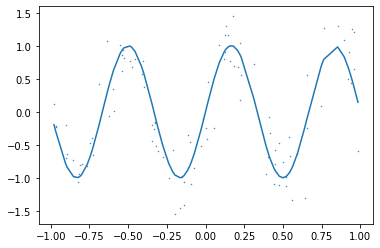

In [187]:

n_train = 100
noise_var = 0.2

ind_points = np.random.uniform(-1., 1., size=(n_train)).astype(dtype)
ind_points.sort(axis=0)
y_true = np.sin(3 * np.pi * ind_points)
y_obs = y_true + np.random.normal(scale=np.sqrt(noise_var), size=y_true.shape).astype(dtype)

plt.plot(ind_points, y_true)
plt.scatter(ind_points, y_obs, s=0.2)

In [188]:
gp_joint = tfd.JointDistributionNamed(dict(
    amplitude = tfd.LogNormal(loc=0., scale=1.),
    length_scale = tfd.LogNormal(loc=0., scale=1.),
    obs_noise_var = tfd.LogNormal(loc=0., scale=1.),
    obs = lambda amplitude, length_scale, obs_noise_var:
        tfd.GaussianProcess(
            kernel=tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude, length_scale),
            index_points=ind_points[:, None],
            observation_noise_variance=obs_noise_var
        )
))

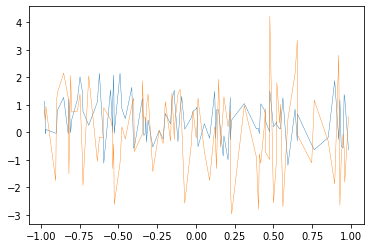

In [207]:
plt.plot(ind_points.ravel(), gp_joint.sample(2)['obs'].numpy().transpose(), lw=0.4)

In [208]:
constrain_positive = tfb.Shift(np.finfo(np.float32).tiny)(tfb.Exp())

amplitude_var = tfp.util.TransformedVariable(1., constrain_positive, name='amplitude')
length_scale_var = tfp.util.TransformedVariable(1., constrain_positive,name='length_scale')
obs_noise_var_var = tfp.util.TransformedVariable(1., constrain_positive, name='obs_noise_var')

trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var,
                       length_scale_var,
                       obs_noise_var_var]]

In [191]:
@tf.function()
def target_log_prob(amplitude, length_scale, obs_noise_var):
  return gp_joint.log_prob({
      'amplitude': amplitude,
      'length_scale': length_scale,
      'obs_noise_var': obs_noise_var,
      'obs': y_obs
  })

Trained parameters:
amplitude: 0.8116680383682251
length_scale: 0.16961173713207245
observation_noise_variance: 0.13786321878433228


Text(0, 0.5, 'Log marginal likelihood')

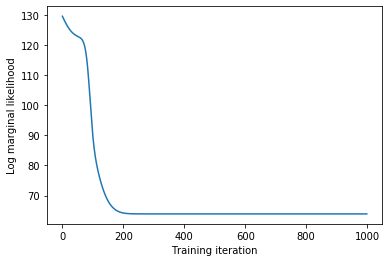

In [192]:
num_iters = 1000
optimizer = tf.optimizers.Adam(learning_rate=.01)

lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
  with tf.GradientTape() as tape:
    loss = -target_log_prob(amplitude_var, length_scale_var, obs_noise_var_var)
  grads = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  lls_[i] = loss

print('Trained parameters:')
print('amplitude: {}'.format(amplitude_var._value().numpy()))
print('length_scale: {}'.format(length_scale_var._value().numpy()))
print('observation_noise_variance: {}'.format(obs_noise_var_var._value().numpy()))

plt.plot(lls_)
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")

In [200]:
# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.

predictive_index_points_ = np.linspace(-1.2, 1.2, 500, dtype=np.float32)

# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

optimized_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(
    amplitude_var, 
    length_scale_var
)
gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=predictive_index_points_,
    observation_index_points=ind_points[:, None],
    observations=y_obs,
    observation_noise_variance=obs_noise_var_var,
    predictive_noise_variance=0.)


num_samples = 100
samples = gprm.sample(num_samples)

Text(0, 0.5, 'Observation space')

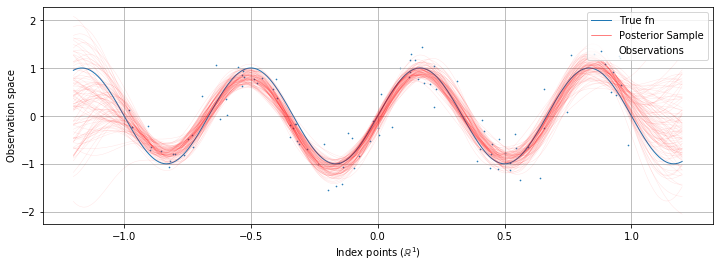

In [204]:
plt.figure(figsize=(12, 4))
plt.grid()
plt.plot(predictive_index_points_, np.sin(3 * np.pi * predictive_index_points_),
         label='True fn', lw=1)
plt.scatter(ind_points, y_obs, s=0.4,
            label='Observations')
for i in range(num_samples):
  plt.plot(predictive_index_points_, samples[i, :], c='r', alpha=.1, lw=0.5,
           label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")

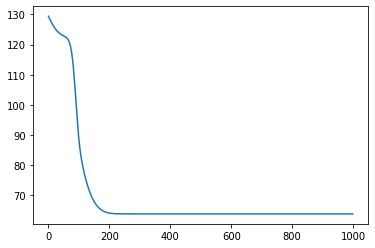

In [216]:
gp_joint = tfd.JointDistributionNamed(dict(
    amplitude = tfd.LogNormal(loc=0., scale=1.),
    length_scale = tfd.LogNormal(loc=0., scale=1.),
    obs_noise_var = tfd.LogNormal(loc=0., scale=1.),
    obs = lambda amplitude, length_scale, obs_noise_var:
        tfd.GaussianProcess(
            kernel=tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude, length_scale),
            index_points=ind_points[:, None],
            observation_noise_variance=obs_noise_var
        )
))

constrain_positive = tfb.Shift(np.finfo(np.float32).tiny)(tfb.Exp())
amplitude_var = tfp.util.TransformedVariable(1., constrain_positive, name='amplitude')
length_scale_var = tfp.util.TransformedVariable(1., constrain_positive,name='length_scale')
obs_noise_var_var = tfp.util.TransformedVariable(1., constrain_positive, name='obs_noise_var')

@tf.function()
def target_log_prob(amplitude, length_scale, obs_noise_var):
  return gp_joint.log_prob({
      'amplitude': amplitude,
      'length_scale': length_scale,
      'obs_noise_var': obs_noise_var,
      'obs': y_obs
  })

num_iters = 1000
optimizer = tf.optimizers.Adam(learning_rate=.01)

trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var,
                       length_scale_var,
                       obs_noise_var_var]]


lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
    with tf.GradientTape(persistent=True) as tape:
        loss = -target_log_prob(amplitude_var, length_scale_var, obs_noise_var_var)

    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
  
    lls_[i] = -target_log_prob(amplitude_var, length_scale_var, obs_noise_var_var)

plt.plot(lls_)
